# Clustering for SP detection

 Will likely need multivew clustering
 
 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scipy.special as scisp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import mixture
import sklearn

import detect_simpsons_paradox as dsp
import sp_data_util as spdata
from sp_data_util import sp_plot,plot_clustermat
import itertools as itert
import string

In [2]:
r_clusters = -.9  # correlation coefficient of clusters
cluster_spread = [.6,.8,.5] # pearson correlation of means
p_sp_clusters = .75 # portion of clusters with SP 
k = [3, 2,5] # number of clusters
cluster_size = [7,1]
domain_range = [0, 20, 0, 20]
N = 200 # number of points
p_clusters =  [[1.0/k_i]*k_i for k_i in k] 
n_views = 3

many_sp_df_diff = spdata.geometric_indep_views_gmm_sp(n_views,r_clusters,cluster_size,cluster_spread,p_sp_clusters,
                domain_range,k,N,p_clusters,numeric_categorical=True)

sp_design_list = [('x1','x2','A'),('x3','x4','B'), ('x5','x6','C')]
many_sp_df_diff.head()

200
6


,x1,x2,x3,x4,x5,x6,A,B,C
0,9.969006,7.959023,13.929605,13.459407,11.394482,15.683631,1,1,4
1,10.017058,14.969321,8.697524,8.456390,6.799178,14.423219,0,0,1
2,11.299198,9.342789,7.939695,9.515422,10.592405,4.663981,1,0,2
3,11.653451,12.875660,9.196237,9.040700,13.505796,10.451985,2,0,0
4,10.301559,8.438822,6.893378,9.411488,4.725297,13.403472,1,0,1


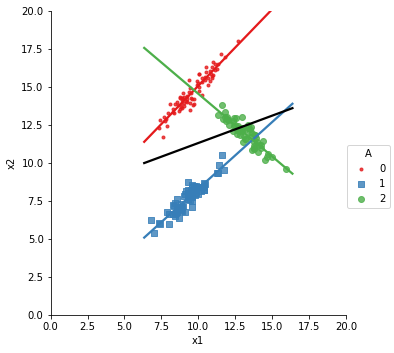

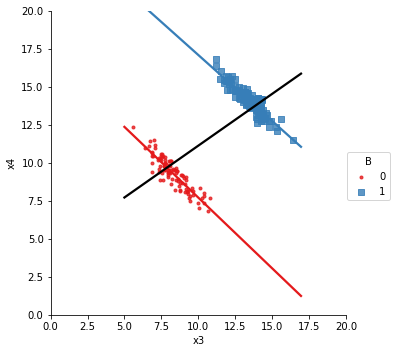

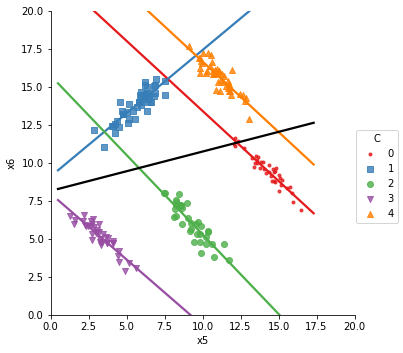

In [3]:
sp_plot(many_sp_df_diff,'x1','x2','A')
sp_plot(many_sp_df_diff,'x3','x4','B')
sp_plot(many_sp_df_diff,'x5','x6','C')


We can represent the relationship between the categorical and continuous variables with a binary matrix, that indicates which categorical varialbes represent known clusters in continuous dimensions.  For the above data this is known and specified a priori, at least mostly.  Since they are draw fully independently, it is possible that ther is a high degree of mutual information between two or more categorical variables and then there would be some errors in the matrix below

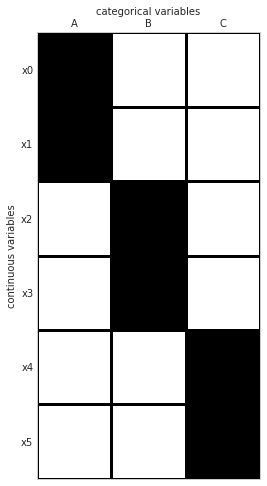

In [4]:
z = [[1, 0, 0],[1, 0, 0],[0,1,0],[0,1,0],[0,0,1],[0,0,1]]
ax = plot_clustermat(z,'list')
plt.xlabel('categorical variables')
plt.gca().xaxis.set_label_position('top') 
plt.xticks([0,1,2],['A','B','C'])
plt.ylabel('continuous variables')
plt.yticks(range(n_views*2),['x'+ str(i) for i in range(n_views*2)]);

In the case where we know this underlying structure, it is straightforward to apply any clustering method, but if we do not know this strucutre, we need a method to detect this structure as well. To explore development of such algorithms we here consider different potential for more varied underlying structure and develop data generators for these.  

# A new clustering model

We clearly want a way that we can cluster in only some dimensions at a time and also we might want a generator that allows more complex data than the binary matrix we had above. The generative model can also help derive the clustering algorithm.

We at least want to for each categorical variable sample its values as a CRP- we don't want to have to set in advance.  We may want to switch to pitman-yor for more control over rich get richer properties.  

Further, we can use a clustering model to assign which continuous variables to sample wrt each categorical variable. 

we can use a dpgmm/ crp model across the multiple dimenions and use worse case a sampler, but probably something like tamara's npb k-means-like formulation . 

an early stoppying criterion for some branches of the inference should be applied such that for views where there is confidence of no SP occurences should be stopped.  

Can we pose the mutliview clustering like a indian buffet process or feature allocation problem instead?


I propose we have a varialbe structure model - that relates the categorical variables to continuous varialbe and a separate clustering model for each categorical variable.  then after that, we will have models for the data generation for the 

## Review of NPB models

First, let's look at the models and see how they look. We'll discuss them first as options for the variable structure model.  

The CRP /Dirichlet process is a clustering model.  

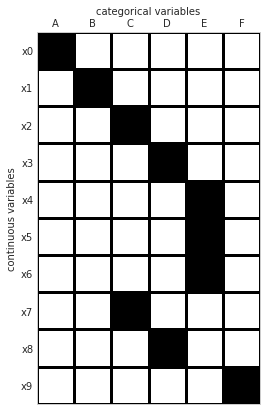

In [5]:
D = 10
alpha = 2

pi = [1]

z = []

for n in range(D):
    # sample from pi
    z.append(np.random.choice(len(pi),p=pi))
    K = max(z) +1
    # update counts
    counts,e = np.histogram(z,bins = np.arange(K+1)-.5)
    # append alpha and normalize to a distribution
    pi = np.append(counts,alpha)/(alpha + n +1.0)

plot_clustermat(z,'crplist')
plt.xlabel('categorical variables')
plt.gca().xaxis.set_label_position('top') 
plt.xticks(range(K),string.ascii_uppercase[:K])
plt.ylabel('continuous variables')
plt.yticks(range(D),['x'+ str(i) for i in range(D)]);

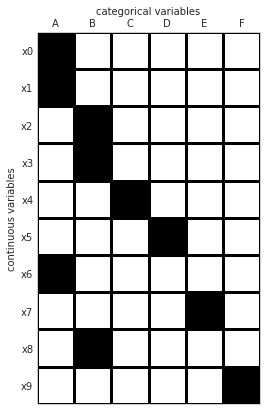

In [10]:
# Pitman yor

D = 10
alpha = 2 # > -d
d= .5 # [0,1)


pi = [1]

z_py = []

for n in range(D):
    # sample from pi
    z_py.append(np.random.choice(len(pi),p=pi))
    K = max(z_py) +1
    # update counts
    
    counts,e = np.histogram(z_py,bins = np.arange(K+1)-.5)
    # append alpha and normalize to a distribution
#     denoms = np.append()
    pi = np.append(counts - d,alpha + d*K)/(alpha + n +1)

plot_clustermat(z_py,'crplist')
plt.xlabel('categorical variables')
plt.gca().xaxis.set_label_position('top') 
plt.xticks(range(K),string.ascii_uppercase[:K])
plt.ylabel('continuous variables')
plt.yticks(range(D),['x'+ str(i) for i in range(D)]);

K_py = max(z_py)

As a variable structure model this assumes no interaction among the categorical varialbes in hwo they influence continuous variables, because each continusou variable is assigned to exactly one categorical variable.  

In [ ]:

#run CRP for each of K dims to sample categorical variables
group_by = []

for k in range(K_py):
    sample_CRP()


# sample continuous variable

## Feature Allocation

We can sample from an indian buffet process to encode interaction between the different categorical varialbes in thier influence on continuous variables.  This structure would be necessary, for example, to have race and gender jointly interact with some measurment (ie: income).  

In [ ]:
# Samle from IBP

# # The first customer takes the first Poisson(gamma)
# dishes. The following customers try previously sampled
# dishes with probability mk/n, where mk is the
# number of people who tried dish k before customer
# n. Each customer also takes Poisson(gamma/n) new dishes.
# The value Znk records if customer n tried dish k.

def p_row(p):
    return np.asarray([np.random.choice([1,0],p=[p_i, 1-p_i]) for p_i in p])


gamma = 2
z = []

z_tmp = np.ones(np.random.poisson(gamma))
m = np.zeros(z_tmp.shape)
z.append(z_tmp)

for n in range(1,D):
    m += z_tmp
#     print(m)
    p = m/(n+1)
#     print(p)
    new = np.random.poisson(gamma/n)
    z_tmp = np.concatenate((p_row(p),np.ones(new)))
    m = np.concatenate((m,np.zeros(new)))
    z.append(z_tmp)
    
K = len(z_tmp)
plot_clustermat(z,'ibplist')
plt.xlabel('categorical variables')
plt.gca().xaxis.set_label_position('top') 
plt.xticks(range(K),string.ascii_uppercase[:K])
plt.ylabel('continuous variables')
plt.yticks(range(D),['x'+ str(i) for i in range(D)]);

However, we might want a somewhat more sparse reltionship, without the strictness of exactly one that the CRP provides. For example, we might want both a small number of continuous dimensions to have intneractions and each one to have a small number of interactions.  Instead of the classical IBP, we can try the 3IBP version from [Broderick, Pitman, Jordan 201x](https://arxiv.org/pdf/1301.6647.pdf).  Additionally, if we flip the role of columns and rows, combined with these new parameters we have enough control.

In [ ]:
gamma = 3
theta = 5 # >0, set to 1 to recover above
alpha = .5 #  in [0,1), set to 0 to revover above

z = []


z_tmp = np.ones(np.random.poisson(gamma))
m = np.zeros(z_tmp.shape)
z.append(z_tmp)

for n in range(2,D):
    m += z_tmp
#     print(m)
    p = [(m_k- alpha)/(n + theta - 1) for m_k in m]
#     print(p)
    G1 = scisp.gamma(theta+1) /scisp.gamma(theta + n )
    G2 = scisp.gamma(theta+ alpha - 1 + n) /scisp.gamma(theta+ alpha)
    new = np.random.poisson(gamma*G1*G2)
    z_tmp = np.concatenate((p_row(p),np.ones(new)))
    m = np.concatenate((m,np.zeros(new)))
    z.append(z_tmp)
    
K = len(z_tmp)
plot_clustermat(z,'ibplist')
plt.ylabel('categorical variables')
plt.gca().xaxis.set_label_position('top') 
plt.yticks(range(D),string.ascii_uppercase[:D])
plt.xlabel('continuous variables')
plt.xticks(range(K),['x'+ str(i) for i in range(K)]);

This flip means that we directly control the number of categorical variables and only probabilisticallly control the number of continuous variables in sampling.  In inference, it means we'll be learning the number of the cntinuos variables that are related to an unobserved categorical variable.  

In [ ]:
n_dim_cat = [sum(z_i) for z_i in z]
n_dim_cat

The above is the number of dimensions for the means for each of the categorical variables.

Then we now have to use the samplers for a CRP for each categorical variable, with additional increases in order to make the interactions happen.  Or that we have to speciy that the means work so that this cn be done and that we have to sample some dependent on one another.  

Whenever two categorical variables influence the same output dimension we need to either sample the conditionnally or figure out hot to make th emean such that it reflets all of the things.  